# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [2]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [4]:
# YOUR CODE HERE
data.loc[18]

artist                                                Drake
verse     Ayy, yeah Pipe this shit up and I turn this sh...
Name: 18, dtype: object

In [10]:
data.verse

0                                 Ayy, woah Ayy, ayy Yeah
1       I'm makin' a change today The liquor been taki...
2       I can't just be with you and only you Yeah, I ...
3       Well, summer, all I did was rest, okay? And Ne...
4       I'm makin' a change today The liquor been taki...
                              ...                        
3970    Dame was like, "Yo you got a deal with Capitol...
3971    Then one day I just went ahead and played it, ...
3972               "I ain't gonna front, it's kinda hot."
3973    Like they still weren't looking at me like a r...
3974    "You gotta be under an umbrella, you'll get ra...
Name: verse, Length: 3975, dtype: object

In [11]:
#function to remove characters and keeping white space
def remove_char (text):
    words_only = ''.join([i for i in text if i.isalpha() or i.isspace()])
    return words_only

In [12]:
#function to clean verse from non standar characters using unidecode , lower and applying is.alpha
def clean_text():
    data.verse = data['verse'].apply(unidecode.unidecode)
    data.verse = data.verse.str.lower()
    data.verse= data.verse.apply(remove_char)
    return data['verse']

In [13]:
data.verse =clean_text()

In [14]:
data.verse

0                                   ayy woah ayy ayy yeah
1       im makin a change today the liquor been takin ...
2       i cant just be with you and only you yeah i go...
3       well summer all i did was rest okay and new ye...
4       im makin a change today the liquor been takin ...
                              ...                        
3970    dame was like yo you got a deal with capitol o...
3971    then one day i just went ahead and played it i...
3972                     i aint gonna front its kinda hot
3973    like they still werent looking at me like a ra...
3974    you gotta be under an umbrella youll get raine...
Name: verse, Length: 3975, dtype: object

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [18]:
data.iloc[4]

artist                                                Drake
verse     im makin a change today the liquor been takin ...
Name: 4, dtype: object

In [40]:
data

,artist,verse
0,Drake,ayy woah ayy ayy yeah
1,Drake,im makin a change today the liquor been takin ...
2,Drake,i cant just be with you and only you yeah i go...
5,Drake,ayy yeah i got one laurie got one and that the...
8,Drake,six yeah yeah yeah
...,...,...
3970,Kanye West,dame was like yo you got a deal with capitol o...
3971,Kanye West,then one day i just went ahead and played it i...
3972,Kanye West,i aint gonna front its kinda hot
3973,Kanye West,like they still werent looking at me like a ra...


In [42]:
# YOUR CODE HERE
data.drop_duplicates(subset ="verse",
                     keep = False, inplace = True)
data.reset_index().drop(columns='index',inplace=True)
data.drop(columns='index',inplace=True)

In [53]:
data

,artist,verse
0,Drake,ayy woah ayy ayy yeah
1,Drake,im makin a change today the liquor been takin ...
2,Drake,i cant just be with you and only you yeah i go...
3,Drake,ayy yeah i got one laurie got one and that the...
4,Drake,six yeah yeah yeah
...,...,...
2375,Kanye West,dame was like yo you got a deal with capitol o...
2376,Kanye West,then one day i just went ahead and played it i...
2377,Kanye West,i aint gonna front its kinda hot
2378,Kanye West,like they still werent looking at me like a ra...


In [54]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [55]:
data.artist.value_counts()

Drake         1152
Kanye West     706
Ed Sheeran     522
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [56]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [57]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [58]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,im,in,me
10,my,it,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [59]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [60]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

13.61% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [64]:
# YOUR CODE HERE
data["seq"] = data.apply(lambda x : tf.keras.preprocessing.text.text_to_word_sequence(x['verse']),axis=1)

In [65]:
data

,artist,verse,seq
0,Drake,ayy woah ayy ayy yeah,"[ayy, woah, ayy, ayy, yeah]"
1,Drake,im makin a change today the liquor been takin ...,"[im, makin, a, change, today, the, liquor, bee..."
2,Drake,i cant just be with you and only you yeah i go...,"[i, cant, just, be, with, you, and, only, you,..."
3,Drake,ayy yeah i got one laurie got one and that the...,"[ayy, yeah, i, got, one, laurie, got, one, and..."
4,Drake,six yeah yeah yeah,"[six, yeah, yeah, yeah]"
...,...,...,...
2375,Kanye West,dame was like yo you got a deal with capitol o...,"[dame, was, like, yo, you, got, a, deal, with,..."
2376,Kanye West,then one day i just went ahead and played it i...,"[then, one, day, i, just, went, ahead, and, pl..."
2377,Kanye West,i aint gonna front its kinda hot,"[i, aint, gonna, front, its, kinda, hot]"
2378,Kanye West,like they still werent looking at me like a ra...,"[like, they, still, werent, looking, at, me, l..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

In [74]:
data['seq'].loc[1]

list

/Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


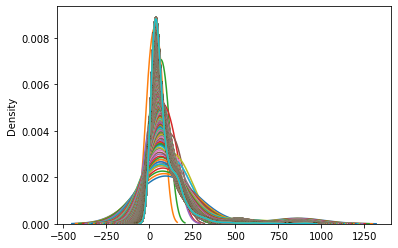

In [78]:
# YOUR CODE HERE
#function to plot distribution of sequences lengths
def plot_seq():
    g = []
    for i in range(len(data)) :
        g.append(len(data['seq'].loc[i]))
        sns.kdeplot(g)
plot_seq()

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [82]:
# YOUR CODE HERE
data.seq.iloc[6][0:300]

['im',
 'from',
 'the',
 'four',
 'but',
 'i',
 'love',
 'me',
 'a',
 'threesome',
 'dm',
 'her',
 'delete',
 'it',
 'she',
 'my',
 'lil',
 'secret',
 'he',
 'tryna',
 'diss',
 'me',
 'to',
 'blow',
 'up',
 'i',
 'peep',
 'it',
 'i',
 'cant',
 'respond',
 'we',
 'just',
 'go',
 'at',
 'your',
 'people',
 'if',
 'i',
 'left',
 'some',
 'racks',
 'on',
 'the',
 'bed',
 'you',
 'can',
 'keep',
 'it',
 'this',
 'shit',
 'gettin',
 'deeper',
 'and',
 'deeper',
 'i',
 'dig',
 'it',
 'my',
 'shovel',
 'wasnt',
 'bent',
 'i',
 'was',
 'broke',
 'had',
 'to',
 'fix',
 'it',
 'a',
 'shark',
 'in',
 'the',
 'water',
 'you',
 'swim',
 'with',
 'the',
 'lil',
 'fishes',
 'i',
 'hit',
 'today',
 'by',
 'tomorrow',
 'she',
 'miss',
 'it',
 'i',
 'grab',
 'her',
 'neck',
 'she',
 'look',
 'up',
 'then',
 'i',
 'kiss',
 'it',
 'im',
 'not',
 'a',
 'goat',
 'but',
 'i',
 'fit',
 'the',
 'description',
 'i',
 'like',
 'to',
 'pour',
 'so',
 'i',
 'get',
 'the',
 'prescription',
 'we',
 'walk',
 'around',

In [ ]:
data.seq.apply()

In [104]:
#function to keep the first 300 words of each sequences
def words_300():
    for x in range(len(data)):
        data.seq.iloc[x] = data.seq.iloc[x][0:300]
    return data.seq

In [110]:
data.seq = words_300()

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [121]:
# YOUR CODE HERE
from gensim.models import Word2Vec
model = Word2Vec(sentences=data.seq, vector_size=100,epochs=50)

In [129]:
#train model


In [19]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [20]:
# YOUR CODE HERE

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [21]:
# YOUR CODE HERE

👉 We train/test split the dataset below for you

In [137]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NameError: name 'X' is not defined

In [136]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

NameError: name 'X' is not defined

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

In [135]:
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)

! rm data_lyrics_solution.pickle

--2021-06-29 16:43:37--  https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.218.122.73
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.218.122.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727513032 (694M) [application/octet-stream]
Saving to: ‘data_lyrics_solution.pickle’

data_lyrics_solutio 100%[===================>] 693.81M  3.31MB/s    in 2m 38s  

2021-06-29 16:46:15 (4.39 MB/s) - ‘data_lyrics_solution.pickle’ saved [727513032/727513032]



❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [169]:
# YOUR CODE HERE
score_baseline = 33.33

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [153]:
# YOUR CODE HERE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras import regularizers
from tensorflow.keras import models
from tensorflow.keras import layers

In [188]:
def initialize_model():
    model = models.Sequential()
    model.add(layers.LSTM(10, input_dim=100, activation='tanh'))
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(3, activation='sigmoid'))
    
    return model

In [189]:
model = initialize_model()

model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm_25/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [177]:
def init_model():
    model = Rec()
    model.add(layers.LSTM(20, return_sequences=False, activation='tanh'))
    model.add(layers.Dense(1, activation='relu'))
    model.add(layers.Dense(3, activation='sigmoid'))
    return model

def compile_model(model):
    model.compile(loss='CategoricalCrossentropy',
              optimizer='rmsprop',
              metrics='accuracy')
    return model

In [178]:
#Fitting of the model
from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model = init_model()
model = compile_model(model)
model.fit(X_train,y_train)

NotImplementedError: in user code:

    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:394 call
        outputs = layer(inputs, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:668 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1153 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:868 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:650 get_initial_state
        init_state = get_initial_state_fn(
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:2516 get_initial_state
        return list(_generate_zero_filled_state_for_cell(
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:2998 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:3014 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/util/nest.py:867 map_structure
        structure[0], [func(*x) for x in entries],
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/util/nest.py:867 <listcomp>
        structure[0], [func(*x) for x in entries],
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:3011 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2911 wrapped
        tensor = fun(*args, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2960 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2896 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:5 prod
        
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3030 prod
        Returns
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:867 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_25/lstm_21/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


In [176]:
from tensorflow.keras.callbacks import EarlyStopping
model = init_model()
model = compile_model(model)

es = EarlyStopping(patience=10)

history = model.fit(X_train, y_train, 
          batch_size=16, 
          epochs=1000, 
          validation_split=0.3,
          callbacks=[es], verbose=0)

NotImplementedError: in user code:

    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:394 call
        outputs = layer(inputs, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:668 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent_v2.py:1153 call
        inputs, initial_state, _ = self._process_inputs(inputs, initial_state, None)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:868 _process_inputs
        initial_state = self.get_initial_state(inputs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:650 get_initial_state
        init_state = get_initial_state_fn(
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:2516 get_initial_state
        return list(_generate_zero_filled_state_for_cell(
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:2998 _generate_zero_filled_state_for_cell
        return _generate_zero_filled_state(batch_size, cell.state_size, dtype)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:3014 _generate_zero_filled_state
        return nest.map_structure(create_zeros, state_size)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/util/nest.py:867 map_structure
        structure[0], [func(*x) for x in entries],
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/util/nest.py:867 <listcomp>
        structure[0], [func(*x) for x in entries],
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:3011 create_zeros
        return array_ops.zeros(init_state_size, dtype=dtype)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2911 wrapped
        tensor = fun(*args, **kwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2960 zeros
        output = _constant_if_small(zero, shape, dtype, name)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py:2896 _constant_if_small
        if np.prod(shape) < 1000:
    <__array_function__ internals>:5 prod
        
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3030 prod
        Returns
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87 _wrapreduction
        return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
    /Users/magloirendabagera/.pyenv/versions/3.8.6/envs/WDF/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:867 __array__
        raise NotImplementedError(

    NotImplementedError: Cannot convert a symbolic Tensor (sequential_24/lstm_20/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported


❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [36]:
# YOUR CODE HERE

❓ **Plot the training and validation losses through training**

In [37]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE
import matplotlib.pyplot as plt
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
plot_loss_accuracy(history)





# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [179]:
# YOUR CODE HERE
score_test = model.score()

AttributeError: 'Sequential' object has no attribute 'score'

🧪 **Send your results below**

In [180]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()

AttributeError: 'Sequential' object has no attribute '_nested_inputs'